# Dealing with uncertainty using heteroscedastic dropout

In [1]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from scipy import stats

from src.data import generate_dataset, generate_sin_shaped_dataset
from src.visualization import beautify_ax

%load_ext autoreload
%autoreload 2

# Generating data
Generating a dataset with a increasing variance. This allows to demonstrate differences in uncertainty, which should be higher when x increases.

In [2]:
np.random.seed(42)
x, x_test, y, y_test = generate_dataset(n=500, test_size=.2)

## Plotting the data

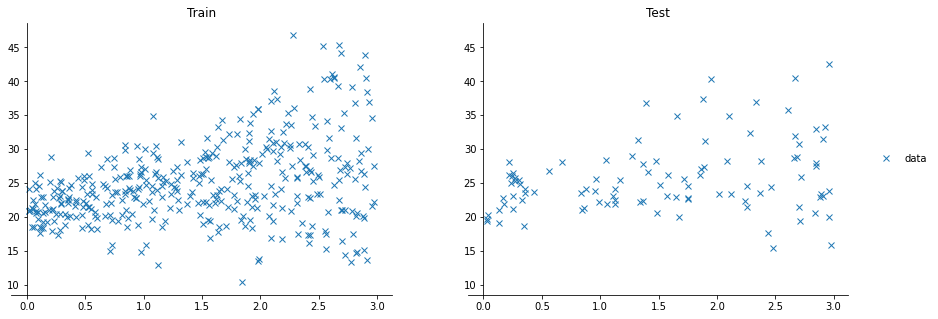

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

axes[0] = beautify_ax(axes[0])  # simple function to format axes as shown below, you can remove this if you prefer
axes[0].plot(x, y, 'x', label='data')
axes[0].set_title("Train")

axes[1] = beautify_ax(axes[1])
axes[1].plot(x_test, y_test, 'x', label='data')
axes[1].set_title("Test")

plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## You can also try something more difficult...
But you probably need to adjust the network to create a proper fit

In [4]:
# x, x_test, y, y_test = generate_sin_shaped_dataset(n=500, test_size=.2)

# fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))

# axes[0] = beautify_ax(axes[0])  # simple function to format axes as shown below, you can remove this if you prefer
# axes[0].plot(x, y, 'x', label='data')
# axes[0].set_title("Train")

# axes[1] = beautify_ax(axes[1])
# axes[1].plot(x_test, y_test, 'x', label='data')
# axes[1].set_title("Test")

# plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));

## Scaling the data
To make sure the feature $x$ and target $y$ are in the same scale

In [5]:
mmsx = MinMaxScaler().fit(x)
x, x_test = mmsx.transform(x), mmsx.transform(x_test)

mmsy = MinMaxScaler().fit(y)
y, y_test = mmsy.transform(y), mmsy.transform(y_test)

In [6]:
class HeteroscedasticDropoutNet(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.model_ = nn.Sequential(
            nn.Linear(params['input_size'], params['hidden_size']),
#             nn.PReLU(),  # when modelling non-linearities
            nn.Dropout(params['dropout_p']),
            nn.Linear(params['hidden_size'], params['output_size'])
        )
        self.optim_ = torch.optim.Adam(
            self.model_.parameters(), 
            lr=params['lr']
        )
    
    def forward(self, X):
        return self.model_(X)
        
    
    def mc_predict(self, X, samples=4000):
        with torch.no_grad():
            self.model_.train()
            preds = torch.stack([self.model_(X) for _ in range(samples)], dim=-1)
        return preds
    
    def save(self, path, fname):
        torch.save({
            "model_state_dict": self.model_.state_dict(),
            "optim_state_dict": self.optim_.state_dict(),
        }, os.path.join(path, fname))
    
    def load(self, path, fname):
        checkpoint = torch.load(os.path.join(path, fname))
        self.model_.load_state_dict(checkpoint['model_state_dict'])
        self.optim_.load_state_dict(checkpoint['optim_state_dict'])
        return self

## Loss and utility functions
- Created a quantile loss function that calculates the loss for all quantiles. 
- A functions that helps creating (evenly spaced) array of 'quantiles'. 

The 'manual' way would look like this:
```python
def gaussian_nll_loss(output, target, sigma):
    sigma = torch.exp(sigma)  
    exp = -((target - output)**2) / (2 * sigma**2)
    log_coef = -torch.log(sigma)
    const = -0.5*np.log(2*np.pi)
    loss = -(exp + log_coef + const).sum()
    
    return loss.sum()
```
But luckily this is a built in feature in `torch.distributions`. You can just call `log_prob()`:

In [7]:
# def gaussian_nll_loss(output, target, sigma):
#     sigma = torch.exp(sigma)
#     dist = torch.distributions.Normal(output, sigma)  # or another distribution if preferred
#     loss = -dist.log_prob(target)
    
#     return loss.sum()

def gaussian_nll_loss(output, target):
    sigma = torch.exp(output[:, 1:])
    dist = torch.distributions.Normal(output[:, :1], sigma)
    loss = -dist.log_prob(target)
    
    return loss.sum()

## Model setup

In [8]:
params = {
    'input_size': 1,
    'output_size': 2,
    'hidden_size': 256,
    'dropout_p': 0.2,
    'batch_size': 128,
    'epochs': 2001,
    'lr': 1e-4,
}
model = HeteroscedasticDropoutNet(params)
criterion = gaussian_nll_loss

## Training the model

In [9]:
x_train, y_train = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
x_val, y_val = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, params['batch_size'], shuffle=True)

In [10]:
for epoch in range(params['epochs']):
    for x_batch, y_batch in train_dl:
        model.train()
        output = model(x_batch)
#         loss = criterion(output[:, :1], y_batch, output[:, 1:])
        loss = criterion(output, y_batch)

        loss.backward()
        model.optim_.step()
        model.optim_.zero_grad()
    
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            output_train = model(x_train)
            mean_train = mean_absolute_error(y_train, output_train[:, :1])
#             train_loss = criterion(output_train[:, :1], y_train, output_train[:, 1:])
            train_loss = criterion(output_train, y_train)
            output_val = model(x_val)
            mean_val = mean_absolute_error(y_val, output_val[:, :1])
#             val_loss = criterion(output_val[:, :1], y_val, output_val[:, 1:])
            val_loss = criterion(output_val, y_val)
    
        print(f"Epoch: {epoch} \t Train loss:{train_loss:.5f} \t Val loss: {val_loss:.5f} \t MAE train: {mean_train:.5f} \t MAE val: {mean_val:.5f}")

Epoch: 0 	 Train loss:762.93427 	 Val loss: 194.23001 	 MAE train: 1.39582 	 MAE val: 1.42335
Epoch: 100 	 Train loss:-150.99219 	 Val loss: -39.08670 	 MAE train: 0.11307 	 MAE val: 0.10478
Epoch: 200 	 Train loss:-197.76384 	 Val loss: -49.49070 	 MAE train: 0.11375 	 MAE val: 0.10731
Epoch: 300 	 Train loss:-236.36192 	 Val loss: -60.61133 	 MAE train: 0.11304 	 MAE val: 0.10557
Epoch: 400 	 Train loss:-250.20776 	 Val loss: -64.41849 	 MAE train: 0.11325 	 MAE val: 0.10594
Epoch: 500 	 Train loss:-254.48892 	 Val loss: -65.48095 	 MAE train: 0.11326 	 MAE val: 0.10600
Epoch: 600 	 Train loss:-255.98503 	 Val loss: -63.49904 	 MAE train: 0.11324 	 MAE val: 0.10682
Epoch: 700 	 Train loss:-255.12735 	 Val loss: -62.48257 	 MAE train: 0.11336 	 MAE val: 0.10698
Epoch: 800 	 Train loss:-256.86472 	 Val loss: -65.26833 	 MAE train: 0.11325 	 MAE val: 0.10645
Epoch: 900 	 Train loss:-256.15610 	 Val loss: -63.46096 	 MAE train: 0.11318 	 MAE val: 0.10662
Epoch: 1000 	 Train loss:-256.914

## Predicting on the train and validation set

In [11]:
preds_train = model.mc_predict(x_train, samples=4000).numpy()
preds_val = model.mc_predict(x_val, samples=4000).numpy()

si_train = x_train.argsort(dim=0).flatten()
train_x_, train_y_hat = x_train[si_train].numpy(), preds_train[si_train, :, :]
train_y_ = y_train[si_train].numpy()

si_val = x_val.argsort(dim=0).flatten()
val_x_, val_y_hat = x_val[si_val].numpy(), preds_val[si_val, :, :]
val_y_ = y_val[si_val].numpy()

In [12]:
def postprocess_samples(samples):
    mus = np.mean(samples[:, 0, :], axis=-1)
    sigmas = np.mean(np.exp(samples[:, 1, :]), axis=-1)
    return mus, sigmas

pred_mu_train, pred_sigma_train = postprocess_samples(train_y_hat)
pred_mu_val, pred_sigma_val = postprocess_samples(val_y_hat)

## Plotting different types of uncertainty

In [20]:
# Dealing with the samples
sampled_mus = train_y_hat[:, 0, :]
mean_mus = sampled_mus.mean(axis=-1)
noises = np.exp(train_y_hat[:, 1, :])

# calculating different uncertainties
aleatoric = (noises**2).mean(axis=-1)**0.5
epistemic = (sampled_mus.std(axis=-1))

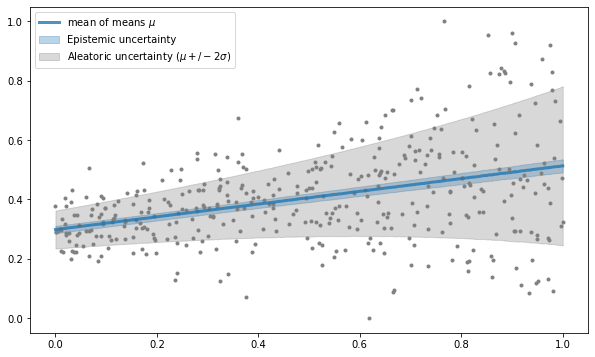

In [21]:
upper_ep = mean_mus + epistemic
lower_ep = mean_mus - epistemic
upper_total = mean_mus + aleatoric  # + 1 sigma
lower_total = mean_mus - aleatoric  # - 1 sigma

plt.figure(figsize=(10,6))
plt.plot(x, y, 'o', c='grey', markersize=3)
plt.plot(train_x_, mean_mus, lw=3, color='tab:blue', alpha=.8, label='mean of means $\mu$')
plt.fill_between(train_x_.flatten(), lower_ep, upper_ep, alpha=.3, color='tab:blue', label='Epistemic uncertainty')
plt.fill_between(train_x_.flatten(), lower_total, upper_total, alpha=.3, color='grey', label='Aleatoric uncertainty ($\mu +/- 2\sigma$)')
# plt.fill_between(train_x_.flatten(), upper_ep, upper_total, alpha=.3, color='grey')
plt.legend();

## Saving model state

In [22]:
model.save(path='../models/', fname='heteroscedastic_mcdropout.pth')

In [23]:
model = HeteroscedasticDropoutNet(params)
model.load(path='../models/', fname='heteroscedastic_mcdropout.pth')

HeteroscedasticDropoutNet(
  (model_): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

## Plotting individual predicted probability distributions
In original data scale. Be aware that you cannot use `inverse_transform()` to transform the sigma back to it's original scale.

[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn-preprocessing-minmaxscaler) scales like this:
```
(X - X.min()) / (X.max() - X.min())
```
when using `inverse_transform()` you multiply `X` with `(X.max() - X.min()`, and add `X.min()`. This last addition should not be added to the standard deviation. Therefore you should only use the `.scale_` attribute of the `MinMaxScaler()`. (SKlearn cakculates the scale by:
```
(1 - 0) / (X.max() - X.min())  # if feature_range=(0,1)
```
You should therefore devide by `.scale_` attribute.

In [24]:
# transform values back to original scale
org_x = mmsx.inverse_transform(val_x_)
org_y = mmsy.inverse_transform(val_y_)  
inv_pred_mu_val = mmsy.inverse_transform(pred_mu_val.reshape(-1,1)).flatten()
inv_pred_sigma_val = pred_sigma_val / mmsy.scale_  

# take 9 random sample (indices)
random_is = np.random.randint(0, len(val_x_), 9)

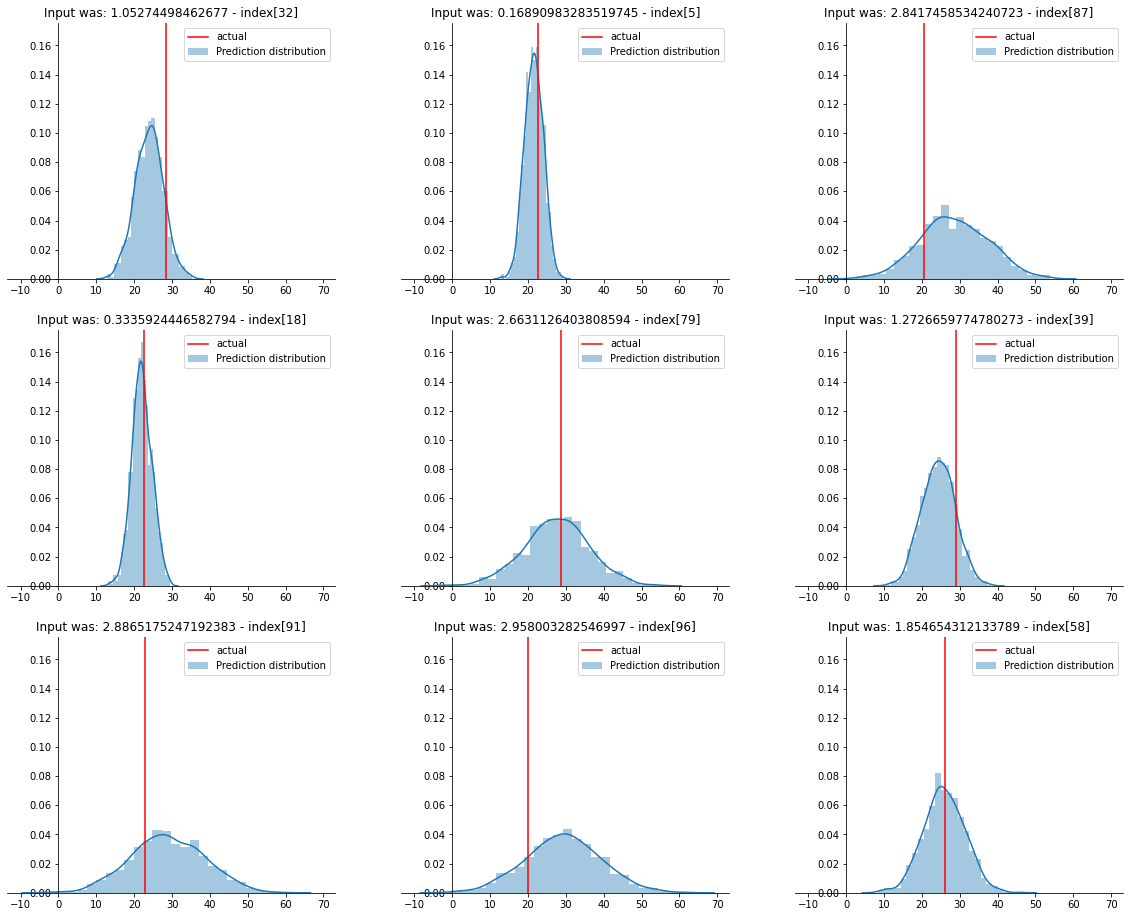

In [25]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))

for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    pred_norm = stats.norm.rvs(size=1000, loc=inv_pred_mu_val[i], scale=inv_pred_sigma_val[i])
    sns.distplot(pred_norm, bins=25, ax=ax, label='Prediction distribution')
    ax.axvline(org_y[i], c='r', label='actual')
    ax.set_title(f"Input was: {org_x[i][0]} - index[{i}]")
    ax.legend();

## Extra
In case we want to get similar results as the MCDQRNN (see notebook 1.0). In this case, we do it exactly the other way around. We first parameterize the posterior distribution (and sample from it), and then we can estimate the quantiles (no quantile crossover!).

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


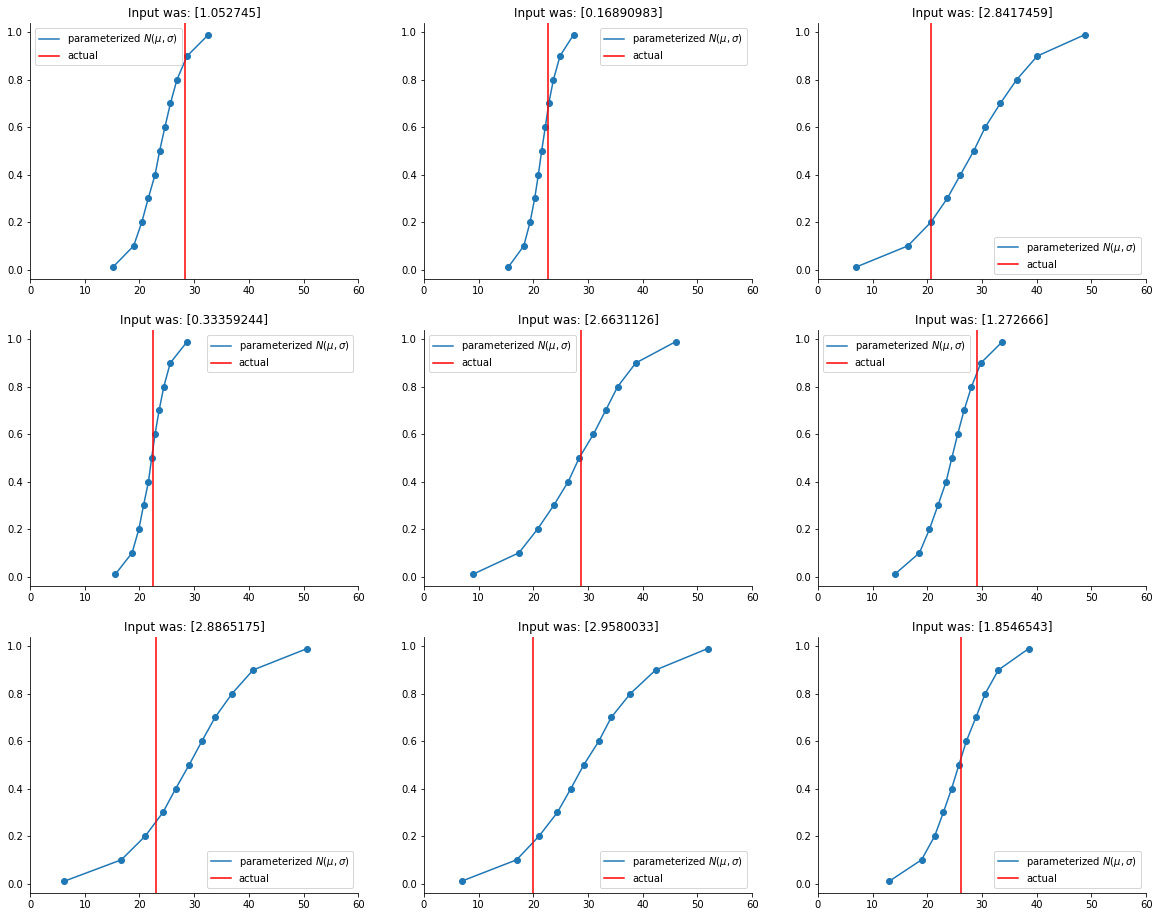

In [19]:
from src.models.quantile_utils import create_quantiles
QUANTILES = create_quantiles(11, min_q=0.01, max_q=0.99)

fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))    
    
for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    pred_norm = stats.norm.rvs(size=1000, loc=inv_pred_mu_val[i], scale=inv_pred_sigma_val[i])
    qs_from_posterior = np.quantile(pred_norm, QUANTILES)
    ax.plot(qs_from_posterior, QUANTILES, label='parameterized $N(\mu,\sigma$)')
    ax.scatter(qs_from_posterior, QUANTILES)
    ax.axvline(org_y[i], c='r', label='actual')
    ax.set_title(f"Input was: {org_x[i]}")
    ax.set_xlim(0, 60)
    ax.legend()
    
plt.show()